In [1]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import yfinance as yf
import pandas as pd
from random import randint
import numpy as np

## Data Preparation

In [2]:
# Using yfinance to retrieve data
# Soybean_ticker = 'ZS=F'
# Soybean_futures_prices = 'zsf'

zsf = yf.Ticker("ZS=F")

# Get stock info
zsf.info

# Get historical market data
hist_soybean_df = zsf.history(start = '2000-09-15', end='2022-03-22')
hist_soybean_df = hist_soybean_df.drop(columns=['Dividends','Stock Splits'])

In [3]:
hist_soybean_df

,Open,High,Low,Close,Volume
Date,,,,,
2000-09-15,491.00,493.75,490.00,493.75,445
2000-09-18,483.25,486.00,482.50,484.00,382
2000-09-19,485.00,485.50,483.50,484.25,325
2000-09-20,483.50,484.25,483.25,483.25,321
2000-09-21,486.75,488.00,486.00,486.50,330
...,...,...,...,...,...
2022-03-15,1674.00,1674.00,1638.00,1658.75,70449
2022-03-16,1661.00,1681.25,1645.25,1649.25,65232
2022-03-17,1649.25,1677.50,1647.25,1668.50,74317


In [4]:
print(len(hist_soybean_df))

5412


In [5]:
# Removing index from soybean dataset

df_soybean = hist_soybean_df.reset_index(level=0)
df_soybean

,Date,Open,High,Low,Close,Volume
0,2000-09-15,491.00,493.75,490.00,493.75,445
1,2000-09-18,483.25,486.00,482.50,484.00,382
2,2000-09-19,485.00,485.50,483.50,484.25,325
3,2000-09-20,483.50,484.25,483.25,483.25,321
4,2000-09-21,486.75,488.00,486.00,486.50,330
...,...,...,...,...,...,...
5407,2022-03-15,1674.00,1674.00,1638.00,1658.75,70449
5408,2022-03-16,1661.00,1681.25,1645.25,1649.25,65232
5409,2022-03-17,1649.25,1677.50,1647.25,1668.50,74317
5410,2022-03-18,1669.75,1689.00,1651.50,1668.00,67110


In [6]:
# X.shape(1 mercado, 5280 dias, 6 features)

In [7]:
# Cheking the maximum number of work days in a year

df_soybean['Date'].dt.year.value_counts()

2020    253
2004    253
2005    253
2008    253
2021    252
2019    252
2015    252
2014    252
2013    252
2011    252
2009    252
2006    252
2003    252
2002    252
2010    252
2007    251
2017    251
2018    251
2012    250
2016    250
2001    247
2000     74
2022     54
Name: Date, dtype: int64

In [8]:
# Checking dataset columns dtype 

df_soybean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5412 entries, 0 to 5411
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    5412 non-null   datetime64[ns]
 1   Open    5412 non-null   float64       
 2   High    5412 non-null   float64       
 3   Low     5412 non-null   float64       
 4   Close   5412 non-null   float64       
 5   Volume  5412 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 253.8 KB


## Creation of Random Time Series Sequences and LSTM Model

In [9]:
# Create a random sequence of 253 days

def subsample_sequence(df, length = 253):
    """
    Given the initial dataframe `df`, return a shorter dataframe sequence of length `length`.
    This shorter sequence should be selected at random
    """
    value = abs(randint(0, len(df) - 2*length))
    df_sample = df[value:length+value]
    return df_sample

In [10]:
# Create X and y from subsample_sequence

def split_subsample_sequence(df, length=253):
    '''Create one single random (X,y) pair'''
    # $CHALLENGIFY_BEGIN
    df_subsample = subsample_sequence(df, length)
    y_samples_index = []
    for step in range(0,23):
        # Pega os 22 próximos index (1 mês) para cada fechamento daquele mês
        index_passado = df_subsample.index[-1] + step
        y_samples_index.append(index_passado)
    # Pega os 22 valores de fechamento referentes aqueles index
    y_sample = df['Close'].to_numpy()[y_samples_index]
    X_sample = df_subsample[0:length -1]
    X_sample = X_sample.values
    # $CHALLENGIFY_END
    return np.array(X_sample), np.array(y_sample)

In [11]:
X,Y = (split_subsample_sequence(df_soybean,253))
print(X.shape,Y.shape)

(252, 6) (23,)


In [12]:
# Create n sequences for model price prediction

def get_X_y(df, n_sequences=300, length=253):
    '''Return a list of samples (X, y)'''
    # $CHALLENGIFY_BEGIN
    X, y = [], []

    for i in range(n_sequences):
        (xi, yi) = split_subsample_sequence(df, length)
        X.append(xi)
        y.append(yi)
        
    X = np.array(X)
    y = np.array(y)
    # $CHALLENGIFY_END
    return X, y

In [13]:
# Checking X and y shapes

X,y = get_X_y(df_soybean,300,253)
X.shape,y.shape

((300, 252, 6), (300, 23))

In [14]:
# Split dataset into test and train 

len_ = int(0.8*df_soybean.shape[0])
df_soybean_train = df_soybean[:len_]
df_soybean_test = df_soybean[len_:]
df_soybean_test.reset_index(drop = True, inplace = True)

In [15]:
df_soybean_test

,Date,Open,High,Low,Close,Volume
0,2017-11-30,992.75,993.00,985.00,985.75,121206
1,2017-12-01,985.75,995.75,985.50,994.25,136840
2,2017-12-04,998.25,1008.50,996.75,998.50,165467
3,2017-12-05,998.50,1015.00,997.50,1008.50,157924
4,2017-12-06,1008.00,1014.25,995.00,1002.75,194108
...,...,...,...,...,...,...
1078,2022-03-15,1674.00,1674.00,1638.00,1658.75,70449
1079,2022-03-16,1661.00,1681.25,1645.25,1649.25,65232
1080,2022-03-17,1649.25,1677.50,1647.25,1668.50,74317
1081,2022-03-18,1669.75,1689.00,1651.50,1668.00,67110


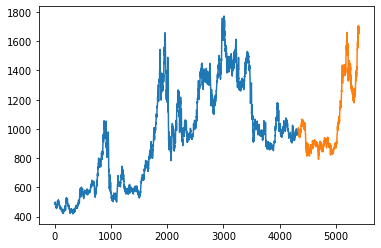

In [16]:
# X_train and X_test

plt.plot(df_soybean_train['Close'])
plt.plot(range(len(df_soybean_train),len(df_soybean_train)+1083),df_soybean_test['Close'])
plt.show()

In [17]:
# Create X_train, y_train, X_test, y_test

X_train, y_train = get_X_y(df_soybean_train, 300, 253)
X_test, y_test = get_X_y(df_soybean_test, 300, 253)

In [18]:
# Remove column Date and transform all columns into float32 dtype

X_train=np.asarray(X_train[:,:,1:]).astype(np.float32)
X_test=np.asarray(X_test[:,:,1:]).astype(np.float32)

In [126]:
# LSTM architecture

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers.experimental.preprocessing import Normalization


def init_model():
    metric = metrics.MAPE
    opt = optimizers.RMSprop(learning_rate=0.01)
    
    normalizer = Normalization()
    normalizer.adapt(np.asarray(X_train))

    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(30,input_shape=(252,5), return_sequences = False, activation='tanh'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(23, activation='linear'))
    
    model.compile(loss='mse', 
                  optimizer=opt, 
                  metrics=[metric])
    
    return model

## Model Evaluation

In [127]:
# Model initialization

model = init_model()
model

In [128]:
# Model summary

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, None, 5)          11        
 ion)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 30)                4320      
                                                                 
 dense_6 (Dense)             (None, 10)                310       
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
 dense_8 (Dense)             (None, 23)                253       
                                                                 
Total params: 5,004
Trainable params: 4,993
Non-trainable params: 11
___________________________________________________

In [129]:
# Model fit with early stopping

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', verbose=1, patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
            validation_split=0.2,
            epochs=100, 
            batch_size=8,
            callbacks=[es], verbose=1)

Epoch 1/100
30/30 [==============================] - 8s 144ms/step - loss: 1017449.8125 - mean_absolute_percentage_error: 96.0432 - val_loss: 839048.2500 - val_mean_absolute_percentage_error: 87.1075
Epoch 2/100
30/30 [==============================] - 3s 106ms/step - loss: 605270.1875 - mean_absolute_percentage_error: 67.5761 - val_loss: 290191.0625 - val_mean_absolute_percentage_error: 43.6145
Epoch 3/100
30/30 [==============================] - 4s 122ms/step - loss: 171081.9219 - mean_absolute_percentage_error: 28.8255 - val_loss: 59824.9805 - val_mean_absolute_percentage_error: 17.5985
Epoch 4/100
30/30 [==============================] - 4s 148ms/step - loss: 35186.2148 - mean_absolute_percentage_error: 12.9311 - val_loss: 14631.7568 - val_mean_absolute_percentage_error: 9.7171
Epoch 5/100
30/30 [==============================] - 4s 117ms/step - loss: 10149.4219 - mean_absolute_percentage_error: 7.0991 - val_loss: 10687.1494 - val_mean_absolute_percentage_error: 10.0132
Epoch 6/100

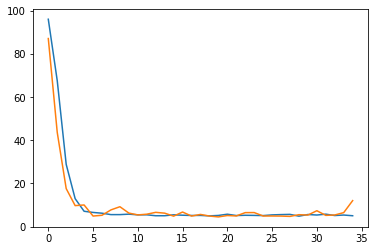

In [130]:
# Comparassion between train and validate datasets

import matplotlib.pyplot as plt
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])

In [65]:
# Evaluation of test dataset

res = model.evaluate(X_test, y_test, verbose=0)

print(f'MAPE on the test set : {res[1]:.2f} %')

MAPE on the test set : 3.26 %


In [66]:
# Predict prices from X_test sample

predict_valor = model.predict(X_test)
predict_valor

array([[954.74585, 955.7255 , 958.5173 , ..., 967.37415, 971.5901 ,
        971.5092 ],
       [921.85944, 922.8986 , 925.50037, ..., 934.073  , 938.2406 ,
        938.07007],
       [863.9763 , 865.0777 , 867.38794, ..., 875.4652 , 879.50323,
        879.21735],
       ...,
       [964.63617, 965.59985, 968.4488 , ..., 977.3865 , 981.62103,
        981.5629 ],
       [835.8635 , 836.9663 , 839.15704, ..., 846.9931 , 850.9399 ,
        850.6254 ],
       [843.16406, 844.268  , 846.4906 , ..., 854.38837, 858.36176,
        858.0523 ]], dtype=float32)

In [67]:
# Checking y_test sample

y_test

array([[940.5 , 934.  , 928.  , ..., 905.  , 905.75, 902.5 ],
       [919.  , 921.  , 915.25, ..., 903.5 , 897.5 , 899.25],
       [870.25, 876.5 , 878.  , ..., 969.5 , 973.  , 979.75],
       ...,
       [936.  , 940.5 , 934.  , ..., 919.5 , 905.  , 905.75],
       [850.25, 847.75, 848.75, ..., 856.5 , 862.5 , 849.75],
       [849.75, 845.  , 845.  , ..., 911.75, 916.25, 915.25]])

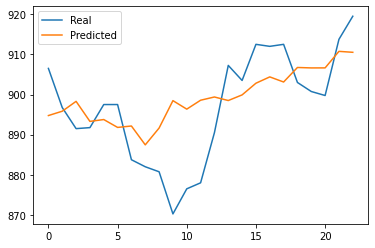

In [68]:
# Plot y_test and predict_valor and check model evaluation from test samples

import matplotlib.pyplot as plt
plt.plot(y_test[111], label = 'Real')
plt.plot(predict_valor[111], label = 'Predicted')
plt.legend()
plt.show()

In [69]:
# Create a X_year_past sample 

X_year_past = df_soybean[-506:-253].drop(columns = 'Date').to_numpy().reshape(1,253,5)

In [70]:
# Checking X_year_past array

X_year_past.shape

(1, 253, 5)

In [71]:
# Predict soybean prices from last year from X_year_past array

y_current_year = model.predict(X_year_past)
y_current_year

array([[1373.5813, 1374.4751, 1379.3676, 1370.4756, 1372.3928, 1369.0986,
        1369.3466, 1361.5918, 1369.222 , 1379.6367, 1375.9669, 1379.6808,
        1380.3273, 1378.6343, 1381.3779, 1385.43  , 1387.7668, 1386.5923,
        1390.4668, 1391.5485, 1391.8534, 1397.4082, 1397.7931]],
      dtype=float32)

In [72]:
# Create y_true_current_year sample

y_true_current_year = df_soybean[-253:-230]['Close']
y_true_current_year

5159    1417.50
5160    1423.25
5161    1432.75
5162    1414.25
5163    1400.50
5164    1393.00
5165    1366.75
5166    1436.75
5167    1402.00
5168    1412.75
5169    1418.75
5170    1408.75
5171    1415.25
5172    1403.00
5173    1382.00
5174    1389.50
5175    1410.00
5176    1418.25
5177    1433.25
5178    1449.75
5179    1472.00
5180    1497.25
5181    1533.25
Name: Close, dtype: float64

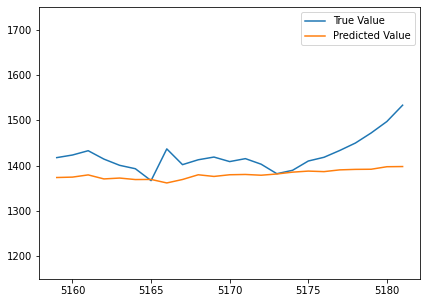

In [73]:
# Comparassion between y_true_current_year and y_current_year

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(y_true_current_year, label = 'True Value')
plt.plot(range(5159,5182),y_current_year[0], label = 'Predicted Value')
plt.ylim(ymin=1150,ymax=1750)
plt.legend()


plt.show()

In [164]:
# Get all dates related to every of 23 predicted prices 

from dateutil.relativedelta import relativedelta
from datetime import datetime

hist_soybean_df = zsf.history(start = '2000-09-15', end='2022-03-22')
hist_soybean_df = hist_soybean_df.drop(columns=['Dividends','Stock Splits'])
soybean_date = hist_soybean_df.reset_index(level=0)
soybean_date = soybean_date['Date']
date = soybean_date.iloc[-1]
month_days = [date + relativedelta(days=+days) for days in range(1,32) if datetime.weekday(date + relativedelta(days=+days)) < 5]
month_days = month_days[:23]
month_days

[Timestamp('2022-03-22 00:00:00'),
 Timestamp('2022-03-23 00:00:00'),
 Timestamp('2022-03-24 00:00:00'),
 Timestamp('2022-03-25 00:00:00'),
 Timestamp('2022-03-28 00:00:00'),
 Timestamp('2022-03-29 00:00:00'),
 Timestamp('2022-03-30 00:00:00'),
 Timestamp('2022-03-31 00:00:00'),
 Timestamp('2022-04-01 00:00:00'),
 Timestamp('2022-04-04 00:00:00'),
 Timestamp('2022-04-05 00:00:00'),
 Timestamp('2022-04-06 00:00:00'),
 Timestamp('2022-04-07 00:00:00'),
 Timestamp('2022-04-08 00:00:00'),
 Timestamp('2022-04-11 00:00:00'),
 Timestamp('2022-04-12 00:00:00'),
 Timestamp('2022-04-13 00:00:00'),
 Timestamp('2022-04-14 00:00:00'),
 Timestamp('2022-04-15 00:00:00'),
 Timestamp('2022-04-18 00:00:00'),
 Timestamp('2022-04-19 00:00:00'),
 Timestamp('2022-04-20 00:00:00'),
 Timestamp('2022-04-21 00:00:00')]

In [165]:
# Create a list wich contains the related date from every predicted price

from dateutil.relativedelta import relativedelta

lista = []
for day in month_days:
    date_format = '%Y/%m/%d'
    month_str = day.strftime(date_format)
    lista.append(month_str)
lista

['2022/03/22',
 '2022/03/23',
 '2022/03/24',
 '2022/03/25',
 '2022/03/28',
 '2022/03/29',
 '2022/03/30',
 '2022/03/31',
 '2022/04/01',
 '2022/04/04',
 '2022/04/05',
 '2022/04/06',
 '2022/04/07',
 '2022/04/08',
 '2022/04/11',
 '2022/04/12',
 '2022/04/13',
 '2022/04/14',
 '2022/04/15',
 '2022/04/18',
 '2022/04/19',
 '2022/04/20',
 '2022/04/21']

In [146]:
# Predict Soy Bean daily closing price starting from 2001-09-24 to present 

lista_valores = []
for i in range(0,len(hist_soybean_df)-253+1):
    if i == len(hist_soybean_df)-253:
        X_past = df_soybean[i:253+i].drop(columns = 'Date').to_numpy().reshape(1,253,5)
        y_year = model.predict(X_past)
        for valor in y_year[0].tolist():
            lista_valores.append(valor)
    else:
        X_past = df_soybean[i:253+i].drop(columns = 'Date').to_numpy().reshape(1,253,5)
        y_year = model.predict(X_past)
        lista_valores.append(y_year[0].tolist()[0])

In [159]:
# Create DataFrame of predicted Soy Bean closing prices 

predicted_sb_prices = pd.DataFrame(lista_valores[:])
predicted_sb_prices = predicted_sb_prices.rename(columns={0: "Predicted Price"})
predicted_sb_prices

,Predicted Price
0,477.428345
1,476.456726
2,474.639374
3,471.491364
4,472.150879
...,...
5177,1582.426025
5178,1582.528564
5179,1585.827026
5180,1577.819092


In [160]:
# Sum 253 to every index value

predicted_sb_prices.reset_index(inplace = True)
predicted_sb_prices['index'] = predicted_sb_prices['index'].apply(lambda x: x+253)
predicted_sb_prices = predicted_sb_prices.set_index("index")
predicted_sb_prices.index.name = None
predicted_sb_prices

,Predicted Price
253,477.428345
254,476.456726
255,474.639374
256,471.491364
257,472.150879
...,...
5430,1582.426025
5431,1582.528564
5432,1585.827026
5433,1577.819092


In [166]:
# Add respective date for each predicted price

predicted_sb_prices['Date'] = df_soybean.iloc[253:]['Date']
predicted_sb_prices.tail(30)

,Predicted Price,Date
5405,1591.040771,2022-03-11
5406,1590.614868,2022-03-14
5407,1600.022583,2022-03-15
5408,1596.845337,2022-03-16
5409,1594.374634,2022-03-17
5410,1595.077637,2022-03-18
5411,1596.384766,2022-03-21
5412,1600.142090,NaN
5413,1592.700806,NaN
5414,1590.293091,NaN


In [167]:
# Add respective date for the last 23 predicted prices

for i in range(len(lista)):
    predicted_sb_prices['Date'].iloc[5159+i] = lista[i]
predicted_sb_prices.tail(30)

/tmp/ipykernel_14190/2391928073.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Predicted Price,Date
5405,1591.040771,2022-03-11
5406,1590.614868,2022-03-14
5407,1600.022583,2022-03-15
5408,1596.845337,2022-03-16
5409,1594.374634,2022-03-17
5410,1595.077637,2022-03-18
5411,1596.384766,2022-03-21
5412,1600.142090,2022/03/22
5413,1592.700806,2022/03/23
5414,1590.293091,2022/03/24


In [169]:
# Save predicted_sb_prices DataFrame into .csv file

# predicted_sb_prices.to_csv('../raw_data/predicted_soybean_prices.csv', index=False)

In [80]:
df_soybean

,Date,Open,High,Low,Close,Volume
0,2000-09-15,491.00,493.75,490.00,493.75,445
1,2000-09-18,483.25,486.00,482.50,484.00,382
2,2000-09-19,485.00,485.50,483.50,484.25,325
3,2000-09-20,483.50,484.25,483.25,483.25,321
4,2000-09-21,486.75,488.00,486.00,486.50,330
...,...,...,...,...,...,...
5407,2022-03-15,1674.00,1674.00,1638.00,1658.75,70449
5408,2022-03-16,1661.00,1681.25,1645.25,1649.25,65232
5409,2022-03-17,1649.25,1677.50,1647.25,1668.50,74317
5410,2022-03-18,1669.75,1689.00,1651.50,1668.00,67110


In [81]:
predicted_sb_prices.head()

,Predicted Price,Date
253,498.369293,2001-09-24
254,497.781006,2001-09-25
255,496.706116,2001-09-26
256,494.820038,2001-09-27
257,495.230103,2001-09-28


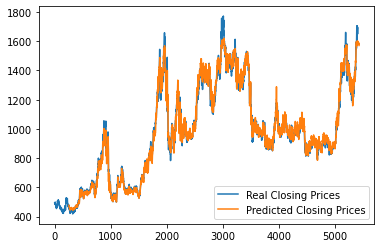

In [168]:
# Comparassion between real closing prices and predicted closing prices

plt.plot(df_soybean['Close'], label='Real Closing Prices')
plt.plot(predicted_sb_prices['Predicted Price'], label='Predicted Closing Prices')
plt.legend()
plt.show()

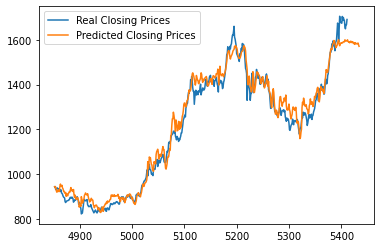

In [170]:
# Model performance after 2019-31-12 (the day Chinese authorities alerted the World Health Organization about COVID-19) 

#len(y_true_total)-4852+23=583
plt.plot(df_soybean['Close'][4852:], label='Real Closing Prices')
plt.plot(predicted_sb_prices['Predicted Price'][-583:], label='Predicted Closing Prices')
plt.legend()
plt.show()

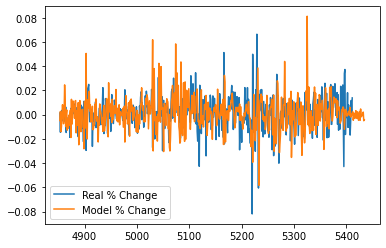

In [171]:
# % change comparassion after covid-19 outbreak

plt.plot(df_soybean['Close'][4852:].pct_change().dropna(), label='Real % Change')
plt.plot(predicted_sb_prices['Predicted Price'][-583:].pct_change().dropna(), label='Model % Change')
plt.legend()
plt.show()

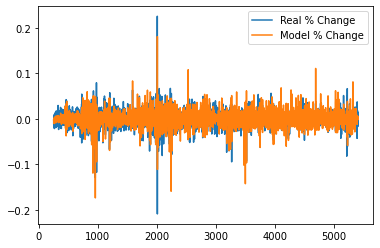

In [172]:
# Historical % change comparassion

plt.plot(df_soybean['Close'][253:].pct_change().dropna(), label='Real % Change')
plt.plot(predicted_sb_prices['Predicted Price'][:-23].pct_change().dropna(), label='Model % Change')
plt.legend()
plt.show()

## Streamlit Graphs

In [86]:
predicted_sb_prices

,Predicted Price,Date
253,498.369293,2001-09-24
254,497.781006,2001-09-25
255,496.706116,2001-09-26
256,494.820038,2001-09-27
257,495.230103,2001-09-28
...,...,...
5430,1587.962036,2022-04-15
5431,1589.377075,2022-04-18
5432,1589.631958,2022-04-19
5433,1596.018433,2022-04-20


In [57]:
import plotly.graph_objects as go

In [175]:
# Create figure

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=list(df_soybean.Date), y=list(df_soybean.Close), name= 'Real Price'))
fig.add_trace(
    go.Scatter(x=list(predicted_sb_prices['Date']), y=list(predicted_sb_prices['Predicted Price']), name= 'Prediction Model'))

    
# Set title
fig.update_layout(
    title_text="Historical Futures Prices for Soybeans"
)

In [176]:
# Add range slider

fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1 Month",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6 Months",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1 Year",
                     step="year",
                     stepmode="backward"),
                dict(label="All",
                    step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()


In [177]:
# Checking conection with API and retrieve predicted values

import requests
url = requests.get("https://soybean-price-prediction-ts7i4cg3ha-ew.a.run.app/predict").json()
url

{'2022/03/22': 1600.14208984375,
 '2022/03/23': 1592.7008056640625,
 '2022/03/24': 1590.2930908203125,
 '2022/03/25': 1591.756591796875,
 '2022/03/28': 1586.774658203125,
 '2022/03/29': 1588.86083984375,
 '2022/03/30': 1594.0572509765625,
 '2022/03/31': 1592.62451171875,
 '2022/04/01': 1587.6942138671875,
 '2022/04/04': 1591.3304443359375,
 '2022/04/05': 1591.5516357421875,
 '2022/04/06': 1584.206787109375,
 '2022/04/07': 1583.1922607421875,
 '2022/04/08': 1587.347412109375,
 '2022/04/11': 1579.913818359375,
 '2022/04/12': 1587.2890625,
 '2022/04/13': 1584.4130859375,
 '2022/04/14': 1582.143310546875,
 '2022/04/15': 1582.426025390625,
 '2022/04/18': 1582.528564453125,
 '2022/04/19': 1585.8270263671875,
 '2022/04/20': 1577.819091796875,
 '2022/04/21': 1571.0777587890625}

In [178]:
url['2022/04/21']

1571.0777587890625

In [179]:
urls = 'https://soybean-price-prediction-ts7i4cg3ha-ew.a.run.app/predict'
resposta = requests.get(urls).json()

In [183]:
import datetime

In [187]:
data1 = datetime.date(2022,3,23)

In [188]:
data2 = data1 - datetime.date(2022,3,22)

In [192]:
print(data2.days)

1


In [195]:
url_nova = list(url)
get_data = url_nova[data2.days]
get_data

'2022/03/23'

In [196]:
url[get_data]

1592.7008056640625

In [ ]:
a_dictionary = {"a": 1, "b": 2, "c":3}
keys_list = list(a_dictionary)
key = keys_list[0]
print(key)
OUTPUT